# Measurement Setup Compensation

The setup compensation is useful for correcting high-frequency errors when measuring low-impedance objects in the mΩ range, where cable inductance is more relevant.  
Due to the variety of cables connected and the different geometries of the objects, Zahner instruments are only calibrated up to the front panel.

The formulas for the correction were derived from a theoretical four terminal network, which corresponds to the parasitic behavior of the measuring device and the setup.  
This formula is universal. It does not depend on the instrument used:

$Z = \frac{(Z_{\text{short}} - Z_{\text{meas}})(Z_{\text{load}} - Z_{\text{open}})}{(Z_{\text{short}} - Z_{\text{load}})(Z_{\text{meas}} - Z_{\text{open}})} \cdot Z_{\text{load,ref}}$

The parameters are explained in the following table:

Parameter|Description 
:---:|:--- 
$Z_{\text{short}}$|Measurement without object. Short-circuited 4-wire test setup. CE, RE, WE power and WE sense are connected together.
$Z_{\text{open}}$|Measurement without object. CE and RE as well as WE power and WE sense are connected to each other.
$Z_{\text{load}}$|Measurement with a reference object of known defined impedance over the frequency range.
$Z_{\text{load,ref}}$|Real impedance of the reference object of $Z_{\text{load}}$ measurement.
$Z_{\text{meas}}$|Measurement to be corrected.
$Z$|Measurement result corrected with the short, open and load data.

The following points must be taken into account:

## ⚠️WARNING⚠️

* **The results must be checked for plausibility, since incorrectly performed short, open and load measurements can also degrade the measurement results.**

* **With a second measurement of a known object it must be verified if the compensation works or if it worsens the result.**

* **The cable routing must not change after the calibration measurement. Since the cable routing and its impedance and parasitic properties are part of the calibration data.**

* **For the best possible correction, the point density of the calibration measurements must be greater than or equal to that of the measurement to be corrected.**

* **The calibration data are smoothed before the calculation, for this the window length and the polynomial order must be defined.**

* **The order of the polynomial and the length of the window must be set by the user, this affects the result.**


In [6]:
from zahner_analysis.analysis_tools.setup_compensation import SetupCompensation
from zahner_analysis.plotting.impedance_plot import bodePlotter
from zahner_analysis.file_import.ism_import import IsmImport
from zahner_analysis.file_export.ism_export import IsmExport
import matplotlib.pyplot as plt

# Load the spectra

First, the measurement to be corrected is loaded and the file name for the corrected measurement is set.

Afterwards the compensation object of the type [SetupCompensation](https://doc.zahner.de/zahner_analysis/analyze/index.html#zahner_analysis.analysis_tools.setup_compensation.SetupCompensation) is initialized. Here only the data must be passed, which are to be used for the compensation. As in the example, it also works only with short data.

The parameters passed with `None` can be omitted, since `None` is also the default parameter.

In [7]:
if __name__ == "__main__":
    originalData = IsmImport("./ExampleData/500uR_measurement_pro.ism")

    compensatedDataFileName = (
        "./ExampleData/500uR_measurement_pro_short_compensated.ism"
    )

    compensationData = SetupCompensation(
        shortData="./ExampleData/short_circuit_measurement_pro.ism",
        openData=None,
        loadData=None,
        referenceData=None,
    )

# Select smoothing parameters

The spectra used for calibration are smoothed with a [Savgol filter from the SciPy Python library](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html).  
The user must select and determine the window length and the polynomial order to be used.

In [8]:
compensationData.setSmoothingWindowLength(3)
compensationData.setSmoothingPolyOrder(2)

# Compensate the original data

With the [compensateIsm](https://doc.zahner.de/zahner_analysis/analyze/index.html#zahner_analysis.analysis_tools.setup_compensation.SetupCompensation.compensateIsm) method of the calibration object created in the previous, the measurements can be compensated by the spectra with which the object was initialized.

In [9]:
compensatedData = compensationData.compensateIsm(originalData)

# Displaying the results

Finally, the original data and the compensated data are plotted together in a diagram.

A new ism-file is also created. This file contains only impedance information. All other information from the original file are lost, such as the parameters of the measurement.

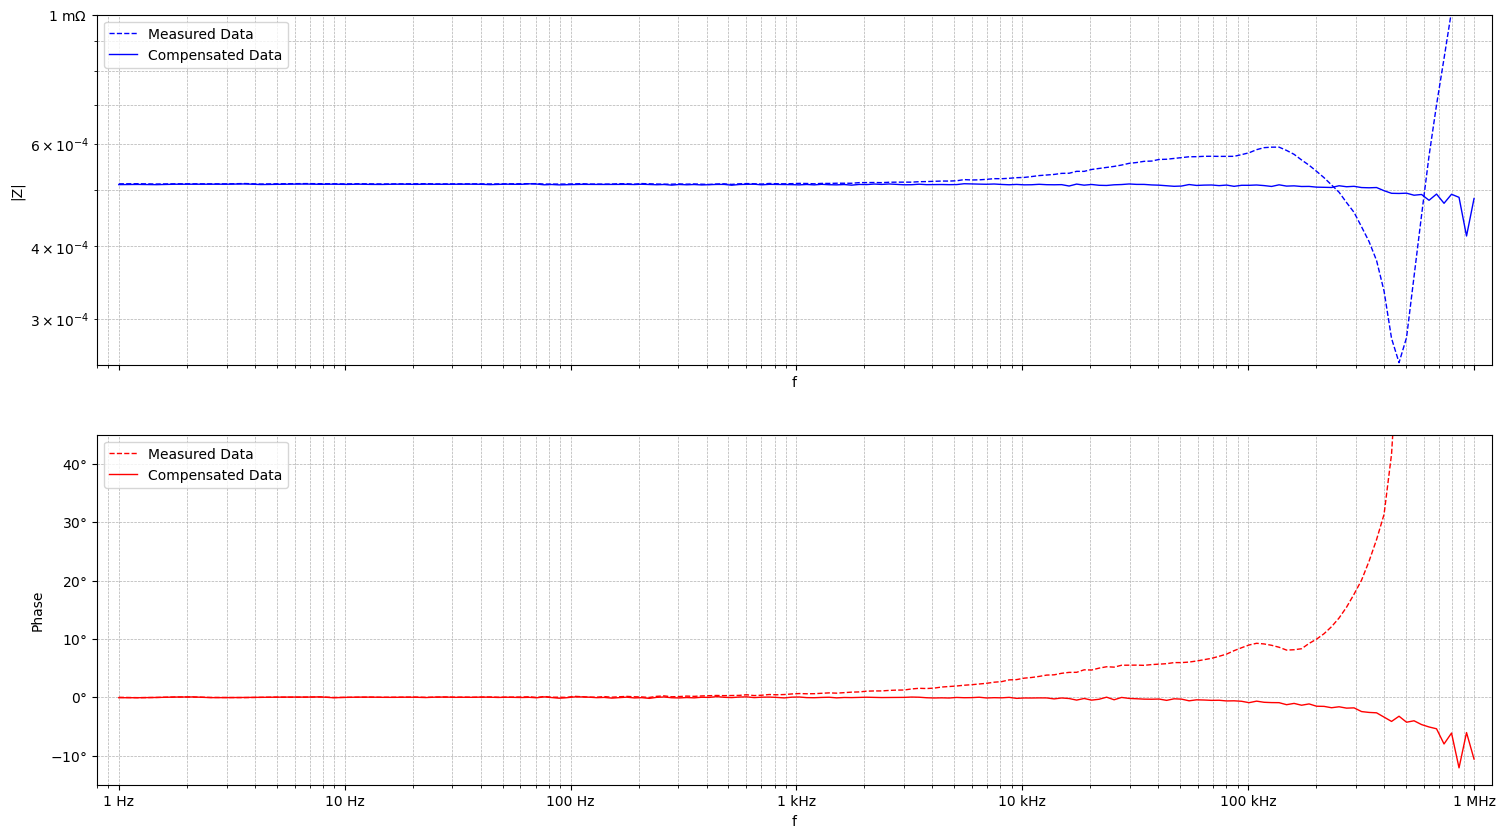

In [10]:
(fig1, (impedanceAxis1, phaseAxis1)) = bodePlotter(
    impedanceObject=originalData,
    zTogetherPhase=False,
    absPhase=False,
    argsImpedanceAxis={"marker": None},
    argsPhaseAxis={"marker": None},
)

(fig1, (impedanceAxis1, phaseAxis1)) = bodePlotter(
    (impedanceAxis1, phaseAxis1),
    impedanceObject=compensatedData,
    zTogetherPhase=False,
    absPhase=False,
    argsImpedanceAxis={"linestyle": "solid", "marker": None},
    argsPhaseAxis={"linestyle": "solid", "marker": None},
)

impedanceAxis1.legend(["Measured Data", "Compensated Data"])
phaseAxis1.legend(["Measured Data", "Compensated Data"])

impedanceAxis1.set_ylim([250e-6, 1e-3])
phaseAxis1.set_ylim([-15.0, +45.0])

fig1.set_size_inches(18, 10)
plt.show()

exportFile = IsmExport(compensatedData)
exportFile.writeToFile(compensatedDataFileName)